# Planetary Data Analysis Notebook

For the first part of this script, I will solely focus on the kNN supervised learning technique applied to the data pertaining to exoplanets from NASA.

In [42]:
# Import necessary libraries
from random import seed
from random import randrange
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from  sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

As a resampling method, will use the train-test-split (tts) method. Will bundle the logic of tts into a function.

In [2]:
seed(1235)
def tts(data, split = 0.80):
    train = list()
    train_size = split*len(data)
    data_copy = list(data)
    while len(train) < train_size :
        index = randrange(len(data_copy))
        train.append(data_copy.pop(index))
    return np.array(train), np.array(data_copy)

In [3]:
# Assign path of data to a variable.
# Initiatiate first data frame with raw data.
path = 'J:\\datasets\\PS_2022.02.27_18.46.12.csv'
raw_data = pd.read_csv(path)

Need to remove the first thirteen rows. These rows contain copious notes/remarks.

In [4]:
raw_data = raw_data.drop(raw_data.index[range(14)])

In [5]:
raw_data

,# This file was produced by the NASA Exoplanet Archive http://exoplanetarchive.ipac.caltech.edu,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
14,pl_name,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim
15,11 Com b,326.03,0.32,-0.32,0,0.231,0.005,-0.005,0
16,11 Com b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,11 UMi b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,11 UMi b,516.21997,3.2,-3.2,0,0.08,0.03,-0.03,0
...,...,...,...,...,...,...,...,...,...
32126,ups And d,1282.41,0.93,-0.94,0,0.294,0.011,-0.012,0
32127,ups And d,1281.507,1.055,-1.055,0,0.316,0.006,-0.006,0
32128,ups Leo b,385.2,2.8,-1.3,0,0.32,0.134,-0.218,0
32129,xi Aql b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
raw_data.columns

Index(['# This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

Notice that the columns are not properly named. Now want to create first data frame with columns of interest.

In [7]:
df1 = raw_data.iloc[:, [0, 1, 5]]
df1.reset_index(drop=True, inplace=True)

Need to rename the columns of interest to make analysis clearer and remove unnecessary rows.

In [8]:
df1 = df1.rename(columns={'# This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu':'planetname', 'Unnamed: 1':'orbitperiod', 'Unnamed: 5':'eccentricity'})
df1 = df1.drop([0])

In [9]:
df1

,planetname,orbitperiod,eccentricity
1,11 Com b,326.03,0.231
2,11 Com b,NaN,NaN
3,11 UMi b,NaN,NaN
4,11 UMi b,516.21997,0.08
5,11 UMi b,516.22,0.08
...,...,...,...
32112,ups And d,1282.41,0.294
32113,ups And d,1281.507,0.316
32114,ups Leo b,385.2,0.32
32115,xi Aql b,NaN,NaN


Data frame 2 will remove all the NA values from original data frame.

In [10]:
df2 = df1.dropna()

In [11]:
df2

,planetname,orbitperiod,eccentricity
1,11 Com b,326.03,0.231
4,11 UMi b,516.21997,0.08
5,11 UMi b,516.22,0.08
7,14 And b,185.84,0
8,14 Her b,1766.41,0.3674
...,...,...,...
32111,ups And d,1274.6,0.242
32112,ups And d,1282.41,0.294
32113,ups And d,1281.507,0.316
32114,ups Leo b,385.2,0.32


The following logic is to determine the data types of the column entries in the latest data.

In [12]:
print(type(df2.iloc[0][1])) # <- Notice the columns are strings and not numeric.
print(type(df2.iloc[0][2]))

<class 'str'>
<class 'str'>


Now to convert just columns "a" and "b". That is, convert the 'orbitperiod' and 'eccentricity' columns into numerics from string data types.

In [13]:
#df2.loc[:, 'orbitperiod'] = df2.loc[:, 'orbitperiod'].apply(pd.to_numeric)
#df2.loc[:, 'eccentricity'] = df2.loc[:, 'eccentricity'].apply(pd.to_numeric)

In [14]:
x1 = df2.iloc[:, 1].apply(pd.to_numeric)
x2 = df2.iloc[:, 2].apply(pd.to_numeric)
x3 = df2.iloc[:,0] #<- this is the column with the column names

In [15]:
x3

1         11 Com b
4         11 UMi b
5         11 UMi b
7         14 And b
8         14 Her b
           ...    
32111    ups And d
32112    ups And d
32113    ups And d
32114    ups Leo b
32116     xi Aql b
Name: planetname, Length: 16511, dtype: object

In [16]:
df2_1 = pd.concat([x3,x1,x2], axis = 1)

In [17]:
df2_1

,planetname,orbitperiod,eccentricity
1,11 Com b,326.03000,0.2310
4,11 UMi b,516.21997,0.0800
5,11 UMi b,516.22000,0.0800
7,14 And b,185.84000,0.0000
8,14 Her b,1766.41000,0.3674
...,...,...,...
32111,ups And d,1274.60000,0.2420
32112,ups And d,1282.41000,0.2940
32113,ups And d,1281.50700,0.3160
32114,ups Leo b,385.20000,0.3200


In [18]:
df2_1.columns

Index(['planetname', 'orbitperiod', 'eccentricity'], dtype='object')

In [19]:
df2

,planetname,orbitperiod,eccentricity
1,11 Com b,326.03,0.231
4,11 UMi b,516.21997,0.08
5,11 UMi b,516.22,0.08
7,14 And b,185.84,0
8,14 Her b,1766.41,0.3674
...,...,...,...
32111,ups And d,1274.6,0.242
32112,ups And d,1282.41,0.294
32113,ups And d,1281.507,0.316
32114,ups Leo b,385.2,0.32


In [20]:
print(df2.dtypes['eccentricity'])

object


In [21]:
print(type(df2))

<class 'pandas.core.frame.DataFrame'>


Dataframe 3 will take the averages of multiple planet entries. Following lines will take arithmetic mean of the two columns of interest and concate the two columns into the third dataframe.

First will create intermediate variables to store the resulting averages.

In [22]:
x4 = df2_1.groupby('planetname')['eccentricity'].mean()
x5 = df2_1.groupby('planetname')['orbitperiod'].mean()

In [23]:
x4
x5

planetname
11 Com b       326.030000
11 UMi b       516.219985
14 And b       185.840000
14 Her b      1766.601670
16 Cyg B b     799.375000
                 ...     
ups And b        4.616229
ups And c      240.728533
ups And d     1285.346167
ups Leo b      385.200000
xi Aql b       136.750000
Name: orbitperiod, Length: 4350, dtype: float64

In [24]:
type(x4)

pandas.core.series.Series

In [25]:
type(x5)

pandas.core.series.Series

In [26]:
df3 = pd.concat([x4, x5], axis = 1)
df3

,eccentricity,orbitperiod
planetname,,
11 Com b,0.231000,326.030000
11 UMi b,0.080000,516.219985
14 And b,0.000000,185.840000
14 Her b,0.362233,1766.601670
16 Cyg B b,0.676033,799.375000
...,...,...
ups And b,0.030200,4.616229
ups And c,0.238933,240.728533
ups And d,0.281117,1285.346167


In [27]:
df3['planetname'] = df3.index
df3

,eccentricity,orbitperiod,planetname
planetname,,,
11 Com b,0.231000,326.030000,11 Com b
11 UMi b,0.080000,516.219985,11 UMi b
14 And b,0.000000,185.840000,14 And b
14 Her b,0.362233,1766.601670,14 Her b
16 Cyg B b,0.676033,799.375000,16 Cyg B b
...,...,...,...
ups And b,0.030200,4.616229,ups And b
ups And c,0.238933,240.728533,ups And c
ups And d,0.281117,1285.346167,ups And d


df3 has the final version of the 'raw' data frame.

In [28]:
df3.columns

Index(['eccentricity', 'orbitperiod', 'planetname'], dtype='object')

    In this part want to explicitly declare the median and IQR of the two columns which are the variables.

In [29]:
ecce = df3['eccentricity']
orbper = df3['orbitperiod']
eccen_med = statistics.median(list(ecce))
orbper_med = statistics.median(list(orbper))
print('\nThe median of the orbital period: %.2f' % orbper_med)
print('\nThe median of the eccentricity: %.2f' % eccen_med)
iqr_ecce = stats.iqr(ecce, interpolation = 'midpoint')
iqr_op = stats.iqr(orbper, interpolation = 'midpoint')
print('\nThe interquartile range of the eccentricity: %.2f' % iqr_ecce)
print('\nThe interquartile range of the orbital period: %.2f' % iqr_op)


The median of the orbital period: 12.24

The median of the eccentricity: 0.00

The interquartile range of the eccentricity: 0.07

The interquartile range of the orbital period: 39.74


The next section of code will use Robust Scaling to properly scale the dataframe. I want to use the kNN supervised learning model, but it is distance based and thus sensitive to scale of the data points.

In [30]:
x6 = df3[['orbitperiod', 'eccentricity']]
x6

,orbitperiod,eccentricity
planetname,,
11 Com b,326.030000,0.231000
11 UMi b,516.219985,0.080000
14 And b,185.840000,0.000000
14 Her b,1766.601670,0.362233
16 Cyg B b,799.375000,0.676033
...,...,...
ups And b,4.616229,0.030200
ups And c,240.728533,0.238933
ups And d,1285.346167,0.281117


In [31]:
rs = RobustScaler().fit(x6)
transformer = rs.transform(x6)

In [32]:
type(transformer)

numpy.ndarray

In [33]:
len(transformer)

4350

In [34]:
transformer

array([[ 7.89441041,  3.55384615],
       [12.67921542,  1.23076923],
       [ 4.36750642,  0.        ],
       ...,
       [32.02891364,  4.32487179],
       [ 9.38301094,  4.92307692],
       [ 3.13249882,  0.        ]])

In [35]:
transformer.shape

(4350, 2)

In [36]:
X = transformer[:, 0]
y = transformer[:, 1]

Now to split the data into training and testing using the test-train-split function defined earlier in the script.

In [37]:
x_train, x_test = tts(X)
y_train, y_test = tts(y)

In [38]:
x_train, y_train = pd.DataFrame(x_train), pd.DataFrame(y_train)
x_test, y_test = pd.DataFrame(x_test), pd.DataFrame(y_test)
print('\nTraining x shape: ', x_train.shape)
print('Training y shape: ', y_train.shape)
print('Test x shape: ', x_test.shape)
print('Test y shape: ', y_test.shape)


Training x shape:  (3480, 1)
Training y shape:  (3480, 1)
Test x shape:  (870, 1)
Test y shape:  (870, 1)


Will run kNN for various values of n_neighbors and store results.

In [39]:
knn_r_acc = []
for j in range(1, 45, 1):
    knn = KNeighborsRegressor(n_neighbors = j)
    knn.fit(x_train, y_train)
    
    test_score = knn.score(x_test, y_test)
    train_score = knn.score(x_train, y_train)
    
    knn_r_acc.append((j, test_score, train_score))
   
results = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(results)
print(results.iloc[:,1].max())

     k  Test Score  Train Score
0    1   -1.068823     0.999775
1    2   -0.572854     0.506134
2    3   -0.408909     0.323022
3    4   -0.282372     0.253357
4    5   -0.254127     0.195590
5    6   -0.218316     0.170535
6    7   -0.181841     0.148097
7    8   -0.167690     0.135940
8    9   -0.153476     0.120632
9   10   -0.149448     0.108893
10  11   -0.143835     0.102367
11  12   -0.139627     0.088249
12  13   -0.131116     0.076876
13  14   -0.111690     0.073561
14  15   -0.108438     0.065628
15  16   -0.100892     0.061265
16  17   -0.095995     0.059774
17  18   -0.092875     0.060669
18  19   -0.087040     0.055752
19  20   -0.085376     0.052759
20  21   -0.082320     0.050781
21  22   -0.072211     0.049791
22  23   -0.072042     0.049305
23  24   -0.071743     0.050625
24  25   -0.074958     0.049901
25  26   -0.072556     0.047064
26  27   -0.071761     0.046137
27  28   -0.069067     0.042491
28  29   -0.065491     0.041813
29  30   -0.061571     0.040114
30  31  

According to the results above, k = 29 seems to be the best k. What is concerning is that I feel if I extended the 'for' loop to a higher value, perhaps I would see a better performing k value.

Now, by adjusting the range of for loop to 45, found the optimal k to be k = 40.

Will now create the kNN model.

In [40]:
model_knn = KNeighborsRegressor(n_neighbors = 40)
model_knn.fit(x_train, y_train)
y_knn_train_pred = model_knn.predict(x_train)
y_knn_test_pred = model_knn.predict(x_test)

For model performace, first the training mean square error and R2 score.

In [43]:
knn_train_mse = mean_squared_error(y_train, y_knn_train_pred)
knn_train_r2 = r2_score(y_train, y_knn_train_pred)
# Now, test mean square and r2 score.
knn_test_mse = mean_squared_error(y_test, y_knn_test_pred)
knn_test_r2 = r2_score(y_test, y_knn_test_pred)
# Consolidate the results.
knn_results = pd.DataFrame(['k Nearest Neighbor', knn_train_mse, knn_train_r2, knn_test_mse, knn_test_r2]).transpose()
knn_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
print(knn_results)

               Method Training MSE Training R2  Test MSE  Test R2
0  k Nearest Neighbor     4.217756    0.033087  4.202917 -0.04222


In [44]:
len(y_knn_test_pred)

870

In [45]:
len(y_test)

870

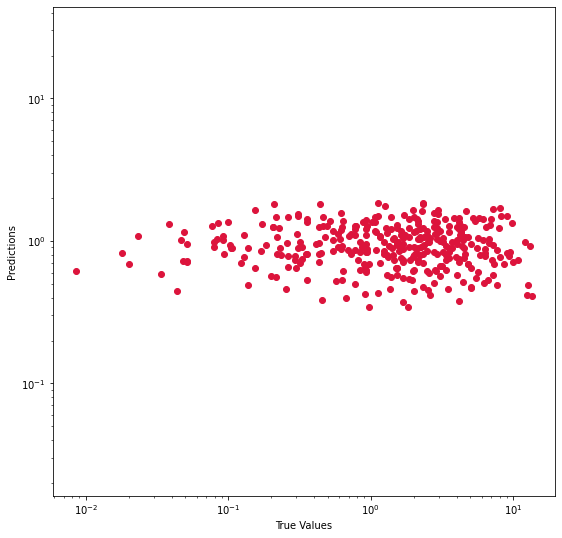

In [74]:
true_values = y_test
predicted_values = y_knn_test_pred
plt.figure(figsize = (9,9))
plt.scatter(true_values, predicted_values, c = 'crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_values), max(true_values))
p2 = min(min(predicted_values), min(true_values))
#plt.plot([p1, p2], [p1, p2], 'b-')

plt.xlabel('True Values', fontsize = 10)
plt.ylabel('Predictions', fontsize = 10)
plt.axis('equal')
plt.show()